In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def d_t(x, y):
    return 0.5 * (np.linalg.norm(x - y))**2

In [3]:
def epsilon_schedule(t=0): return 0.1 # return 1 / (1 + t)
def alpha_schedule(t=0): return 0.01
def rho_schedule(i=0): return 1.0

In [4]:
def prob_p_kji(N, M):
    p_kji = np.full((N, M, M), 0.05 / (M - 1))  # Default: uniform for k ≠ j

    for i in range(N):
        for j in range(M):
            p_kji[i, j, j] = 0.95  # Set p(k = j | j, i)

    return p_kji

In [5]:
def reinforcement_clustering(
    beta_min, beta_max, tau, M, X, episodes=100, GD_iter=100, tol=1e-6
):

    N, d = X.shape
    beta = beta_min
    pi = np.full((N, M), 1 / M)
    centroid = np.mean(X, axis=0)
    Y = np.tile(centroid, (M, 1))  # Duplicate the centroid M times
    d_bar = np.zeros((N, M))
    prob = prob_p_kji(N, M)
    t = 0  # time step (used for schedules)

    buffer = np.ones((N, M, M))  # keep memory of interactions

    while beta <= beta_max:
        for _ in range(episodes):  # Outer convergence loop
            i = np.random.randint(N)
            j = np.argmax(pi[i])  # this hould be greedy
            k = np.random.choice(M, p=prob[i, j, :])
            buffer[i, j, k] += 1
            eps = epsilon_schedule(t)
            d_bar[i, j] = eps * d_t(X[i], Y[j]) + (1 - eps) * d_t(X[i], Y[k])
        d_mins = np.mean(d_bar, axis=1, keepdims=True)
        pi = np.exp(-beta * (d_bar - d_mins))
        pi /= pi.sum(axis=1, keepdims=True)  # shape (N, M)
        transitipn_prob = buffer / np.sum(
            buffer, axis=2, keepdims=True
        )  # shape (N, M, M)
        derivs = np.zeros_like(Y)  # shape (M , 2)
        for _ in range(GD_iter):  # Inner convergence loop
            # for l in range(M):
            #     pi_p = np.sum(transitipn_prob[:,:,l] * pi , axis = 1, keepdims= True)
            #     derivs[l] = np.sum((Y[l] - X) * pi_p, axis= 0)
            pi_p_all = np.sum(transitipn_prob * pi[:, :, None], axis=1)
            diff = Y[:, None, :] - X[None, :, :]
            derivs = np.sum(diff * pi_p_all.T[:, :, None], axis=1)
            Y = Y - alpha_schedule(t) * derivs
            if np.linalg.norm(derivs) < tol:
                break
            t += 1  # increment time step

        beta *= tau  # annealing

    return pi, Y

In [6]:
# Example synthetic data
X = np.vstack(
    [
        np.random.randn(50, 2) + np.array([2, 2]),
        np.random.randn(50, 2) + np.array([-2, -2]),
    ]
)

beta_min = 0.01
beta_max = 20.0
tau = 1.1
M = 2  # number of clusters

pi_star, Y_final = reinforcement_clustering(beta_min, beta_max, tau, M, X)

print("Final Centroids (Y):")
print(Y_final)

Final Centroids (Y):
[[ 2.05783048  1.75468207]
 [-1.77836375 -1.80537523]]


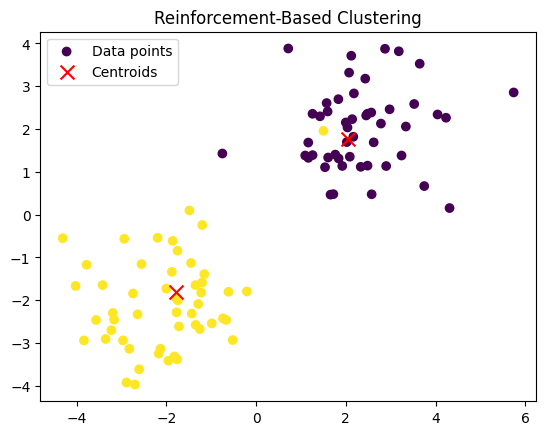

In [7]:
assignments = np.argmax(pi_star, axis=1)

plt.scatter(X[:, 0], X[:, 1], c=assignments, cmap="viridis", label="Data points")
plt.scatter(Y_final[:, 0], Y_final[:, 1], c="red", marker="x", s=100, label="Centroids")
plt.title("Reinforcement-Based Clustering")
plt.legend()
plt.show()

In [8]:
pi_star

array([[1.00000000e+000, 1.04080324e-091],
       [1.00000000e+000, 2.11527194e-061],
       [1.00000000e+000, 1.27199693e-128],
       [1.00000000e+000, 4.08754978e-148],
       [1.00000000e+000, 2.56331641e-115],
       [1.00000000e+000, 1.94013440e-064],
       [1.00000000e+000, 3.90757475e-125],
       [1.00000000e+000, 1.20566578e-177],
       [1.00000000e+000, 1.19036862e-069],
       [1.00000000e+000, 7.67904589e-011],
       [1.00000000e+000, 1.31317992e-072],
       [1.00000000e+000, 2.05425924e-057],
       [1.00000000e+000, 1.18439450e-160],
       [1.00000000e+000, 1.56252299e-021],
       [6.84011854e-059, 1.00000000e+000],
       [1.00000000e+000, 7.88525101e-132],
       [1.00000000e+000, 7.48119408e-137],
       [1.00000000e+000, 7.64914208e-078],
       [1.00000000e+000, 7.49760497e-083],
       [1.00000000e+000, 7.05436883e-180],
       [1.00000000e+000, 1.02760233e-093],
       [1.00000000e+000, 4.61004715e-081],
       [1.00000000e+000, 4.08749416e-118],
       [1.0